# Project 2020

## Project for Machine Learning and Statistics in 2020.

### Introduction
The objective of this project is to create a web service that uses machine learning to make predictions based on the *powerproduction* data set. The project consiste of the following elements:

* Jupyter notebook, in the following notebook, I train a number of models which aim to accurately predicts wind turbine power output from wind speed values, found in the data set. Contained in the notebook, I explain each model and give an analysis of its accuracy.

* A python script, which uses the best model. This script will run the web service. A copy of the script is available in the repository.

* A dockerfile to build and run the web service in a container. This will respond with predicted power values based on speed values sent as HTTP requests. A copy of the dockerfile is available in the repository.


### Import Libraries

In [38]:
# Efficient numerical arrays.
import numpy as np
# Data frames.
import pandas as pd
# Alternative statistics package.
import statsmodels.stats.weightstats as stat
# Mains statistics package.
import scipy.stats as ss
# Plotting.
import matplotlib.pyplot as plt
# Fancier plotting.
import seaborn as sns

# Better sized plots.
plt.rcParams['figure.figsize'] = (12, 8)

# Nicer colours and styles for plots.
plt.style.use("fivethirtyeight")

### Load Data

In [39]:
# Load the powerproduction dataset from a csv file using read_csv function into dataframe called df
# adapted from Willems (2017) and McLoughlin (2019)
df = pd.read_csv("powerproduction.csv")
# Display the dataframe
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


### 1.4 Review Data Types <a id='types'></a>

Sharma (2018) recommends that once the data has been loaded, the next step is to review the data-type / features of the data.

Data-Types / Features fall into the following categories:
* numeric (Integers / Floats)
* categorical (Class)
* ordinal (Data that can be ranked in an order)  
* datetime
* coordinates

The Pandas dataframe.dtypes command is used to display the data types/features of dataset

In [40]:
# Use DataFrame.dtypes command to find out the data type (dtype) of each column in the given dataframe. 
df.dtypes

speed    float64
power    float64
dtype: object

In [41]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


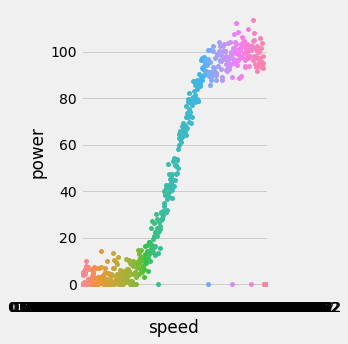

In [42]:
# One type of plot available in seaborn.
sns.catplot(x='speed', y='power', jitter=False, data=df);

### 1.5 Data Set Description <a id='description'></a>

By loading the data set and displaying the dataframe and running the dataframe.dtypes command , it's possible to determine some basic details of the dataset as follows: 

* The powerproduction data set is a comma-separated values (csv) file with 500 records (rows of data) and 2 fields (columns).
    * Each record (row of data) is located on a separate line, delimited by a line break. 
    * The fields of data in the header line and each record (row) are delimited with a comma. 
    * Each row or data is indexed, the index is shown in the column on the left, but the index is not part of the dataset itself.
* The first line of the file is the header line, containing the names of the 2 fields: "speed","power".
    * The two columns; "speed","power", contain floats.
    * The "speed" column displays wind speed data - the unit of measure is meter per second, it is assumed this is a measure of wind intensity as opposed to maximum wind speed. According to the Met Office (2020)  wind intensity is defined by the average wind speed over a ten minute period being reported. 
    * The "power" column displays power output which is measure in kilowatts (Pickerel, 2010).
* Reviewing the values of Mean, Std, Min, Median(median represents the 50th percentile or the middle value of the data), and Max.
    * The wind speeds column seems to follow the pattern of a normal distribution
    * The power output column, showns a large difference between Min and MAX, their difference in Mean and median too, which means this column is noisy and this is borne out by the visualization.

## 2.0 Data Cleaning <a id='cleaning'></a>

Data cleaning is the process of ensuring that your data is correct and useable by identifying any errors in the data, or missing data by correcting or deleting them (Sharma, 2018). 

### 2.1 Detect Missing Data <a id='missing'></a>

Sharma (2018) highlights missing data as a common issue with data sets and can occur when no data value is recorded for the variable in an observation. Missing data can have a significant impact on the conclusions that can be drawn from the data. 

In [43]:
# Check if the dataframe has missing data using the pandas.isnull(obj) function. 
# adapted from https://confusedcoders.com/data-science/cleaning-data-for-data-visualisation
df.isnull().sum() #detect missing values 
# The below results indicate that no data is missing from the array.

speed    0
power    0
dtype: int64

### 2.2 First and Last DataFrame Rows <a id='first'></a>

Having established some basic details about the data set, Willems (2017) suggests that its good idea to take a closer look at the data itself. I used the pandas head() and tail() functions take a look the first and last lines of the data set to see if there was anything unusual.

In [44]:
# Inspect the first 5 rows - adapted from https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [45]:
# Inspect the last 5 rows - adapted from https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python
df.tail()

,speed,power
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0
499,25.000,0.0


### 2.3 Data Cleaning Results  <a id='clean'></a>

The results of the review of the data contained in the first and last dataframe rows are as follows:

* The power output for the first and last 5 rows in the data set was zero. This was unexpected and needs further investigation. 

## 3.0 Data Pre-Processing <a id='preprocessing'></a>

Now that I have confirmed that the data is clean the next step is to prepare the data for analysis (data preprocessing).

Sharma (2018), describes data preprocessing as a data analysis technique that involves transforming raw data into an understandable format. Preprocessing activities include normalisation and standardisation, transformation, feature extraction and selection. The output of data preprocessing is the final training dataset.

### 3.4 Outliers <a id='outliers'></a>

Willems (2017), describes outliers as data that contain values that diverge heavily from the majority of other data. These values are easily identified when you plot the data as the data points appear to lie outside the “expected” area of the plot. Outliers are often caused by data entry or recording errors. Your data needs to be screened for outliers as they can have a signficant effect on the results of the typical summary statistics and can influence the machine learning algorithms such as Linear Regression Models.

Willems (2017) suggests some approachs to handling outliers, including deleting the values, transforming the values using an algorithm (e.g. K Nearest Neighbours), or  replacing the values with the mean/mode/median value. Before deciding which approach is best, you first need to have a clear understanding of the data and the likely causes of the outliers.  

#### 3.4.1 Removal of Records With Zero Value Power Output <a id='outliers'></a>
As we have seen from the head and tail that zero value power output is a feature of the dataset. According to the US Dept of Energy (2020), for wind turbines to operate there must be a minimum wind speeds of between 8 to 16 miles per hour (7.5 meters per second) and a maximum wind speed of about 55 mph (24.5 meters per second). Wind turbines can be damaged at wind speeds above about 55 mph. 
* The dataset contains records where the power output is zero, where the wind speeds are outside the recommended operating parameters outlined by the US Dept of Energy. Therefore, I will treat these as outliers and remove the values from the dataset.
* There four records where the power outpout is zero and the wind speed is within the normal operating parameters. This is not expected, there is no reason provided, but it could be assumed that the turbines may have been taken offline for maintenance etc. I will treat these 4 records as outliers and remove the values from the dataset. 


In [46]:
# Remove "Zero" Values
newdf = df[(df.power > 0)] 
newdf

,speed,power
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


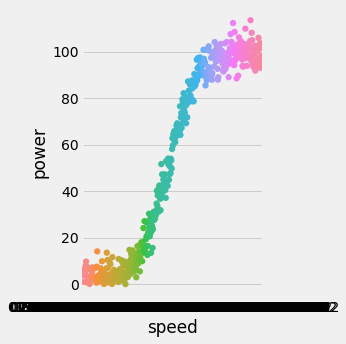

In [47]:
# One type of plot available in seaborn.
sns.catplot(x='speed', y='power',sizes=(40, 400), legend="full", jitter=False, data=newdf);

## 4.0 Linear Regression <a id='linear'></a>

In this section, I will briefly describe what regression is and the types of linear regression methodologies. I will explain to use Simple Linear Regression to to produce a model to accurately predict wind turbine power output from wind speed
values, using the powerproduction dataseet to train the model. I use Scikit-Learn, which is "one of the most popular machine learning libraries for Python" (Pathak, 2020).

#### How regression works and when to use it. <a id='linear'></a>

According to Frost (2019), regression models can be used to predict changes to a dependent variable (y) given changes to one or more predictor variables (x). There are two types of Linear Regression methodologies:

1. Simple Linear Regression 
Simple linear regression algorithm identifies if there is a linear relationship between variables; x (input) and y(output), Pathak(2020).  This relationship is represented in the form:  Y= ax + b 
Where 'b' is the intercept and 'a' is the slope of the line. The linear regression algorithm fits multiple lines on the data points and returns the line that results in the best fit (least error), (Pathak, 2020).

2. Multiple Linear Regression
Multiple linear regression is used where there are more than two variables. In this scenario, the dependent variable(y) variable) is dependent upon more than one independent variables (Pathak, 2020). A regression model involving multiple variables can be represented as:
y = b0 + a1b1 + a2b2 + a3b3 + … … anbn

I have decided to use Simple Linear Regression as there are only two variables. However Multiple Linear Regression could be used if additional variables were included in the data set. According to Pickerel, 2020, other variables which determine power output include:

  * The rotor area, the larger the rotor, the more energy it generates.
  * The air density, air density is a function of air temperature and elevation, the standard rating assumes 15° C at sea level. As air density changes with elevation, this can affect output.  


### 4.1 Simple Linear Regression <a id='simple'></a>

Simple linear regression is used to identify a straight-line which best fits to data. 
Stojiljkovic (2019) outlines five basic steps in implementing linear regression:

1. Import the packages and classes.
2. Provide the data to analyse.
3. Create a regression model and fit it with the data.
4. Check the results of model fitting and decide whether to accept or reject the model.
5. Make predictions using the model.

#### 4.1.1 Import Packages and Classes

In [48]:
# The first step is to import the class LinearRegression from sklearn.linear_model adapted from Stojiljkovic (2019)
# The class sklearn.linear_model.LinearRegression will be used to perform linear regression using the Ordinary Least Squares model to fit this data and construct the best-fit line
from sklearn.linear_model import LinearRegression

#### 4.1.2 Provide Data
The second step is defining data you wish to analyse. This involves defining the input (predictor variable, the x) and output (dependent variable, the 𝑦), these variables should be in the form of NumPy arrays (Stojiljkovic, 2019).

In [49]:
# Create array consisting of the two columns; x and y variables
predictors = newdf[['speed', 'power']]
# display shapes, 2 columns.
predictors.shape
# print the shape of the array

(451, 2)

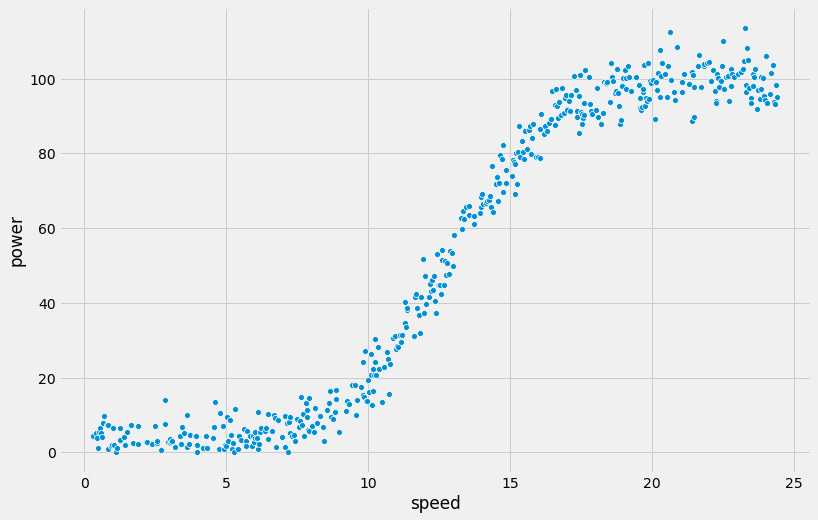

In [50]:
# Create a simple scatterplot to visualize the data
sns.scatterplot(x='speed', y='power', sizes=(40, 400), legend="full", data=predictors)
# print scatterplot

In [51]:
# Solution adapted from Lalitha 2017
# Convert the input variable 'Total Bill' into an array XX: 
XX = np.asarray(predictors['speed']) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html
# Convert 1 array XX into 2D array called X2 in the shape of a column vector by inserting an axis along second dimension
X2 = XX[:, np.newaxis] # https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae
# Print shape of X2 array
X2.shape

(451, 1)

In [52]:
y2 = predictors['power']
y2.shape

(451,)

#### 5.1.3 Create a regression model and fit it 

In [53]:
# Create an instance of the class LinearRegression, called model representing the regression model (Stojiljkovic, 2019).
# Define Parameters 
    # Define the parameters of the regression model, source https://realpython.com/linear-regression-in-python/
    # fit_intercept=True , the y-intercept will be determined by the line of best fit. https://stackoverflow.com/a/46781428
    # normalize is a Boolean (False by default) that decides whether to normalize the input variables (True) or not (False).
    # copy_X is a Boolean (True by default) that decides whether to copy (True) or overwrite the input variables (False).
    # n_jobs is an integer or None (default) and represents the number of jobs used in parallel computation. None usually means one job and -1 to use all processors.

# call .fit() on model: 
model = LinearRegression(fit_intercept=True).fit(X2, y2)
# Print Model
model

LinearRegression()

#### 4.1.4 Get Results

In [54]:
r_sq = model.score(X2, y2)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8984832870534454


In [55]:
# Regression coefficients - adapted from Lalitha (2017)
# Regression coefficients are estimates of the unknown population parameters and describe the relationship between a predictor variable and the response. 
# In linear regression, coefficients are the values that multiply the predictor values. 
# Use sklearn coef function to display the coefficient for the line of best fit taken from 'model'
r_coef = model.coef_
print('regression coefficient (slope):', r_coef)

regression coefficient (slope): [5.61882784]


In [56]:
constant = model.intercept_
print('y intercept:', constant)

y intercept: -19.837685452108396


#### 4.1.5 Predict response
Once you are happy with the model, the next step is to predict the response using some test data

In [57]:
# Create test data adapted from Lalitha (2017)
# Generate 244 samples in range 0 to 51 (which approximates range of bills) using NumPy Random Randint function
Xfit = np.random.uniform(25,size=(244))
# astype is used to convert integers to floats in Pandas DataFrame: https://datatofish.com/integer-to-float-dataframe/
Xfit.astype(float)
# Convert 1D array Xfit into 2D array in the shape of a column vector by inserting an axis along second dimension
Xfit = Xfit[:, np.newaxis] # https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae
# display the shape of an array Xfit
Xfit.shape # adapted from https://stackoverflow.com/a/10200284


(244, 1)

In [58]:
# To obtain the predicted response, use .predict(): (Stojiljkovic, 2019).
yfit = (model.predict(Xfit))
print('predicted response:', yfit, sep='\n')
# Answer

predicted response:
[ 28.62018339  33.80393073  98.46769427  19.11489209  64.4702474
 117.25264524  93.24822087  65.72440395 101.26958486  91.03331698
   7.11625936 108.67097459  22.02083972  16.57142649  82.25952615
  98.84151419  22.71624894  -2.21538739  11.47201802 108.35657308
  14.93861426  31.23037909  90.46930885  55.81336242  24.05872756
  25.21697555  94.04481544  13.77270636  25.44620452  43.57630889
 105.10293674  16.14997619  93.02654473  90.2209109   12.32637356
  -1.61752999   9.57566748 105.93660571  80.40880222  52.66008575
  26.41323833 108.18524222  54.45361762  81.35130997  76.89128945
  90.05237345  25.61478778  66.6367242   34.43922712 106.85480322
  30.51441877  31.06707263 -11.67710868  50.18855243  26.41859645
   7.60820175  11.78874557  57.66901633 113.49877185 105.94673014
  25.58268891 -12.78310299 114.90931107  13.39376839  56.92893991
  84.61925079  97.23146602  53.2649757   75.5948254   22.70404624
   2.70925209  74.03864511  54.17670203  44.87412181 100.

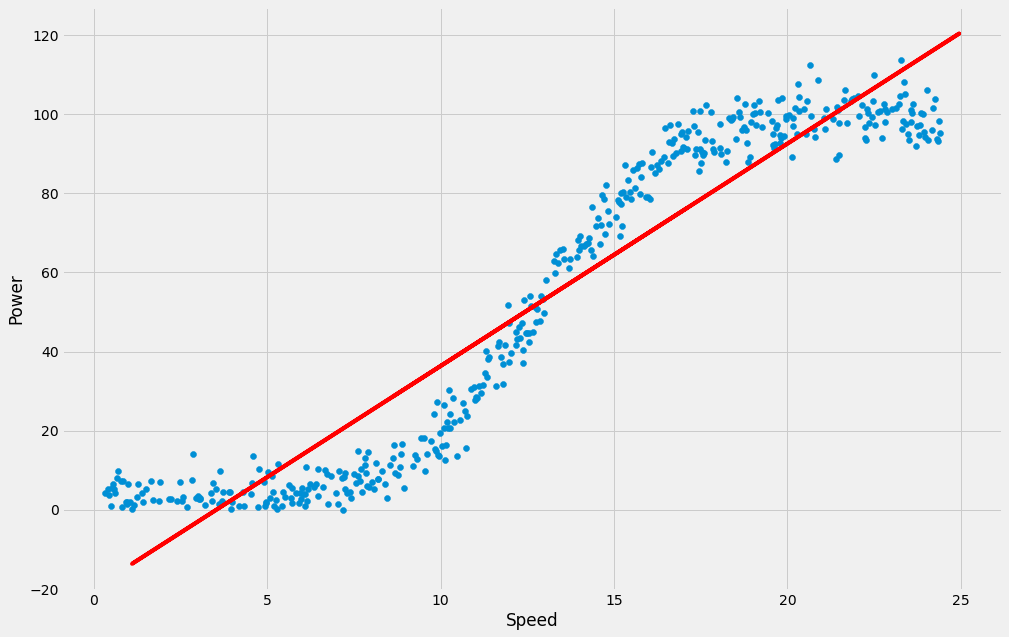

In [59]:
# Visualize the results

# Resize Plot to creates a figure with 15 (width) x 10 (height) inches - Adapted from https://stackoverflow.com/a/36368418
plt.figure(figsize=(15,10))
plt.xlabel('Speed') # Label x Axis 
plt.ylabel('Power') # Label y Axis 

# Create a scatter plot of X2 and y2 and plot the regression line which is the predicted response when data is input into the regression model
plt.scatter(X2, y2)
plt.plot(Xfit, yfit,color="red")
plt.show()

In [60]:
# Testspeed is an array containing 1 float, value 15.5, representing 15.5 meters per second. adapted from Stojiljkovic (2019).
Testspeed = np.array([15.5]) # https://docs.scipy.org/doc/numpy/user/basics.creation.html

# Convert 1D array Xfit into 2D array in the shape of a column vector by inserting an axis along second dimension
Testspeed = Testspeed[:, np.newaxis] 
# display the shape of an array Testbill
Testspeed.shape # adapted from https://stackoverflow.com/a/10200284

(1, 1)

In [61]:
# Predict powr output for wind speed of 15.5 meters/secons
# To obtain the predicted response, use .predict():adapted from Stojiljkovic (2019).
y_pred = (model.predict(Testspeed))
print('Predicted output (kw) if windspeed is 15.5 meters per second is:', y_pred)

Predicted output (kw) if windspeed is 15.5 meters per second is: [67.25414603]


### 4.2 Evaluation of Linear Regression
* The coefficient of determination: 0.8984832870534454 means that power output is 89.8% predictable. 
* While this result is encouraging when we visualize the results, we can infer that linear regression is not fitting the data.
* The regression model does not fit because the relationship between the dependent and independent variables is not linera to begin with.
* Therefore we should reject linear regression and consider using polynomial regression to see if it leads to a better fit.

## 5.0 Polynomial Regression <a id='linear'></a>
Polynomial regression is a regression technique which involves the use of non linear equations to describe the relationship between two dependent variables. It is normally used to describe functions, which when plotted, are not linear in shape (Singh, 2018).  

Polynomial regression differs from linear regression by including extra predictors, obtained by raising each of the original predictors to a power. For example, a cubic regression uses three variables, $x^1$,$x^2$,$x^3$ as predictors. (Singh, 2018).  

Polynominal regression replaces the linear model with a polynomial function - for example cubic regression can be expressed as: 𝑓(𝑥) = 𝑏₀ + 𝑏₁𝑥 + 𝑏₂𝑥²+ 𝑏₃𝑥₁³. ( Stojiljkovic, 2019)



In [62]:
# Step 1: Import packages and classes - solution adapted from Stojiljkovic (2019).
# import the class PolynomialFeatures from sklearn.preprocessing:
from sklearn.preprocessing import PolynomialFeatures

In [63]:
#Step 2a: Provide data

XX = np.asarray(predictors['speed']) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html
# Convert 1 array XX into 2D array called X2 in the shape of a column vector by inserting an axis along second dimension
X2 = XX[:, np.newaxis] # https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae
# Print shape of X2 array
X2.shape



(451, 1)

In [64]:
#Step 2b: Transform input data
# degree is an integer 3 (2 by default) that represents the degree of the polynomial regression function.
x_2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X2)
x_3 = PolynomialFeatures(degree=5, include_bias=False).fit_transform(X2)
x_4 = PolynomialFeatures(degree=10, include_bias=False).fit_transform(X2)
x_5 = PolynomialFeatures(degree=11, include_bias=False).fit_transform(X2)

In [65]:
#x_ = transformer.transform(x)
x_2.shape
x_3.shape
x_4.shape
x_5.shape

(451, 11)

In [66]:
y = predictors['power']
y.shape


(451,)

In [67]:
model1 = LinearRegression(fit_intercept=False).fit(x_2, y)
model2 = LinearRegression(fit_intercept=False).fit(x_3, y)
model3 = LinearRegression(fit_intercept=False).fit(x_4, y)
model4 = LinearRegression(fit_intercept=False).fit(x_5, y)

In [71]:
# Model 1
r_sq = model1.score(x_2, y)
print('Model 1: coefficient of determination:', r_sq)
print('Model 1: intercept:', model1.intercept_)
print('Model 1: coefficients:', model1.coef_)
# Model 2
r_sq2 = model2.score(x_3, y)
print('Model 2: coefficient of determination:', r_sq2)
print('Model 2: intercept:', model2.intercept_)
print('Model 2: coefficients:', model2.coef_)
# Model 3
r_sq3 = model3.score(x_4, y)
print('Model 3: coefficient of determination:', r_sq3)
print('Model 3: intercept:', model3.intercept_)
print('Model 3: coefficients:', model3.coef_)
# Model 4
r_sq4 = model4.score(x_5, y)
print('Model 4: coefficient of determination:', r_sq4)
print('Model 4: intercept:', model4.intercept_)
print('Model 4: coefficients:', model4.coef_)

Model 1: coefficient of determination: 0.88316542202907
Model 1: intercept: 0.0
Model 1: coefficients: [2.3287779  0.11343664]
Model 2: coefficient of determination: 0.9878834199306614
Model 2: intercept: 0.0
Model 2: coefficients: [ 9.13611298e+00 -3.66661665e+00  4.96295762e-01 -2.35981241e-02
  3.71789065e-04]
Model 3: coefficient of determination: 0.990108472419433
Model 3: intercept: 0.0
Model 3: coefficients: [ 1.16021534e+01 -1.02996369e+01  4.19380829e+00 -9.18442845e-01
  1.16621187e-01 -8.84828509e-03  4.05962046e-04 -1.10195194e-05
  1.62523399e-07 -1.00143934e-09]
Model 4: coefficient of determination: 0.9900153612134668
Model 4: intercept: 0.0
Model 4: coefficients: [ 4.28155630e+00  1.14305427e+00 -2.40650451e+00  1.04815726e+00
 -2.30117302e-01  2.97750247e-02 -2.38799143e-03  1.20001815e-04
 -3.68105539e-06  6.31046390e-08 -4.64024610e-10]


In [69]:
y_pred1 = model1.predict(x_2)
y_pred2 = model2.predict(x_3)
y_pred3 = model3.predict(x_4)
y_pred4 = model4.predict(x_5)
##print('predicted response:', y_pred, sep='\n')

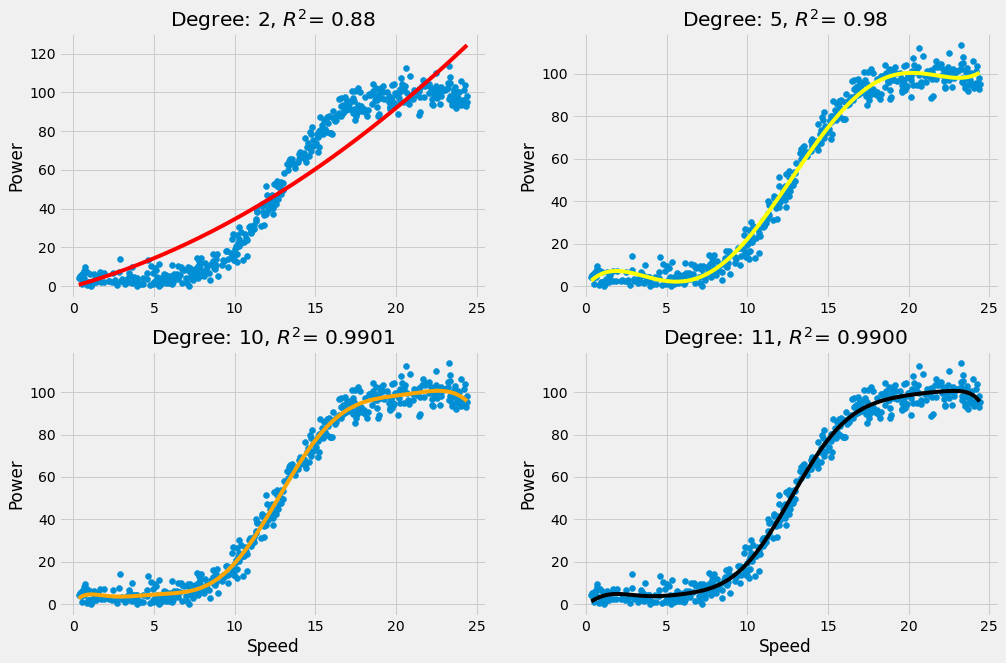

In [72]:
# Visualize the results adapted from Matplotlib 2020

# Resize Plot to creates a figure with 15 (width) x 10 (height) inches - Adapted from https://stackoverflow.com/a/36368418
plt.figure(figsize=(15,10))


# Create a scatter plot of X2 and y2 and plot the regression line using model1
plt.subplot(221)
plt.title('Degree: 2, $R^2$= 0.88') # Formatting RSquared in LaTeX adapted Johansson, J & Fangohr, H (2016)
#plt.xlabel('Speed') # Label x Axis 
plt.ylabel('Power') # Label y Axis 
plt.scatter(X2, y2)
plt.plot(X2, y_pred1,color="red")

# Create a scatter plot of X2 and y2 and plot the regression line using model2
plt.subplot(222)
plt.title('Degree: 5, $R^2$= 0.98')
#plt.xlabel('Speed') # Label x Axis 
plt.ylabel('Power') # Label y Axis 
plt.scatter(X2, y2)
plt.plot(X2, y_pred2,color="yellow")

# Create a scatter plot of X2 and y2 and plot the regression line using model3
plt.subplot(223)
plt.title('Degree: 10, $R^2$= 0.9901')
plt.xlabel('Speed') # Label x Axis 
plt.ylabel('Power') # Label y Axis 
plt.scatter(X2, y2)
plt.plot(X2, y_pred3,color="orange")

# Create a scatter plot of X2 and y2 and plot the regression line using model4
plt.subplot(224)
plt.title('Degree: 11, $R^2$= 0.9900')
plt.xlabel('Speed') # Label x Axis 
plt.ylabel('Power') # Label y Axis 
plt.scatter(X2, y2)
plt.plot(X2, y_pred4,color="black")
plt.show()

### 5.2 Analysis of Polynomial Regression Models

Underfitting and Overfitting
One very important question that might arise when you’re implementing polynomial regression is related to the choice of the optimal degree of the polynomial regression function.

There is no straightforward rule for doing this. It depends on the case. You should, however, be aware of two problems that might follow the choice of the degree: underfitting and overfitting.

Underfitting occurs when a model can’t accurately capture the dependencies among data, usually as a consequence of its own simplicity. It often yields a low 𝑅² with known data and bad generalization capabilities when applied with new data.

Overfitting happens when a model learns both dependencies among data and random fluctuations. In other words, a model learns the existing data too well. Complex models, which have many features or terms, are often prone to overfitting. When applied to known data, such models usually yield high 𝑅². However, they often don’t generalize well and have significantly lower 𝑅² when used with new data.


The top left plot shows a linear regression line that has a low 𝑅². It might also be important that a straight line can’t take into account the fact that the actual response increases as 𝑥 moves away from 25 towards zero. This is likely an example of underfitting.

The top right plot illustrates polynomial regression with the degree equal to 2. In this instance, this might be the optimal degree for modeling this data. The model has a value of 𝑅² that is satisfactory in many cases and shows trends nicely.

The bottom left plot presents polynomial regression with the degree equal to 3. The value of 𝑅² is higher than in the preceding cases. This model behaves better with known data than the previous ones. However, it shows some signs of overfitting, especially for the input values close to 60 where the line starts decreasing, although actual data don’t show that.

Finally, on the bottom right plot, you can see the perfect fit: six points and the polynomial line of the degree 5 (or higher) yield 𝑅² = 1. Each actual response equals its corresponding prediction.

In [81]:
# Testspeed is an array containing 1 float, value 15.5, representing 15.5 meters per second. adapted from Stojiljkovic (2019).
Testspeed2 = np.array([15.5]) # https://docs.scipy.org/doc/numpy/user/basics.creation.html

# Convert 1D array Xfit into 2D array in the shape of a column vector by inserting an axis along second dimension
Testspeed2 = Testspeed2[:, np.newaxis] 
# display the shape of an array Testbill
Testspeed2.shape # adapted from https://stackoverflow.com/a/10200284
s = PolynomialFeatures(degree=10, include_bias=False).fit_transform(Testspeed)

In [82]:
y_pred5 = model3.predict(s)
# Predict powr output for wind speed of 15.5 meters/secons
# To obtain the predicted response, use .predict():adapted from Stojiljkovic (2019).

print('Predicted output (kw) if windspeed is 15.5 meters per second is:', y_pred5)

Predicted output (kw) if windspeed is 15.5 meters per second is: [81.91336476]


In [98]:
# write a function that predicts a power output from an windspeed value entered by the user
def testSpeed(a):
    if a > 7.5 and a < 24.5: 
        Testspeed2 = np.array([a]) # https://docs.scipy.org/doc/numpy/user/basics.creation.html

        # Convert 1D array Xfit into 2D array in the shape of a column vector by inserting an axis along second dimension
        Testspeed2 = Testspeed2[:, np.newaxis] 
        # display the shape of an array Testbill
        Testspeed2.shape # adapted from https://stackoverflow.com/a/10200284
        s = PolynomialFeatures(degree=10, include_bias=False).fit_transform(Testspeed2)
        y_pred5 = model3.predict(s)
        # Predict powr output for wind speed of 15.5 meters/secons
        # To obtain the predicted response, use .predict():adapted from Stojiljkovic (2019).

        print('Predicted output (kw) if windspeed is ', a, ' meters per second is:', y_pred5, 'kilowatts.')
    else:
        print('INVALID ENTRY: Enter a value between 7.5 and 24.5')
testSpeed(21.5)

Predicted output (kw) if windspeed is  21.5  meters per second is: [99.88068115] kilowatts.


## 7.0 References <a id='references'></a>
   1. Met Office (2020) *How we measure wind* [Online] Available at:https://www.metoffice.gov.uk/weather/guides/observations/how-we-measure-wind#:~:text=The%20instruments%20used%20to%20measure,%2D1%20%3D%201.15%20mph) [Accessed 13 Nov 2020]
   1. Pickerel, K (2010) *How to calculate power output of wind* [Online] Available at:https://www.windpowerengineering.com/calculate-wind-power-output/ [Accessed 13 Nov 2020]
   1. Sharma, N (2018) *Cleaning data for data visualisation* [Online] Available 
   https://confusedcoders.com/data-science/cleaning-data-for-data-visualisation [Accessed 13 Nov 2020]
   1. Willems, K (2017) *Python Exploratory Data Analysis Tutorial* [Online] Available at:https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python [Accessed 13 Nov 2020]
   1. US Dept of Energy (2020) *The Inside of a Wind Turbine* [Online] Available at:https://www.energy.gov/eere/wind/inside-wind-turbine#:~:text=Starts%20up%20the%20machine%20at,damaged%20by%20the%20high%20winds. [Accessed 13 Nov 2020]
   1. Pathak, P (2020) *A beginner’s guide to Linear Regression in Python with Scikit-Learn* [Online] Available at:https://medium.com/analytics-vidhya/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-6b0fe70b32d7 [Accessed 13 Nov 2020]
   1. Frost, J (2019) *Regression coefficients* [Online] Available at:https://statisticsbyjim.com/glossary/regression-coefficient/ [Accessed 13 Nov 2020]
   1. Liran, B (2017) *PYTHON MACHINE LEARNING EXAMPLE – LINEAR REGRESSION* [Online] Available at: 
    https://devarea.com/python-machine-learning-example-linear-regression/#.XeDYeej7TIV [Accessed 13 Nov 2020]
   1. Stojiljkovic, M (2019) *Simple Linear Regression With scikit-learn* [Online] Available at:https://realpython.com/linear-regression-in-python/ [Accessed 13 Nov 2020]
   1. Lalitha, R (2017) *Iris Dataset - Exploratory Data Analysis* [Online] Available at:https://realpython.com/linear-regression-in-python/https://www.kaggle.com/lalitharajesh/iris-dataset-exploratory-data-analysis [Accessed 13 Nov 2020]
   1. Willems, K (2017) *Python Exploratory Data Analysis Tutorial* [Online] Available at:https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python [Accessed 13 Nov 2020]
   1. McLoughlin, I (2019) *Descriptive Statistics and Plots with Pandas* [Online] Available at:https://web.microsoftstream.com/video/ecc9ce4a-c6f5-4c50-a4f4-29116fc21b81?referrer=https:%2F%2Flearnonline.gmit.ie%2Fcourse%2Fview.php%3Fid%3D689 [Accessed 13 Nov 2020]
   1. Singh, G (2018) *Introduction to Regression Splines (with Python codes)* [Online] Available at:https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/ [Accessed 13 Nov 2020]
   1. Johansson, J & Fangohr, H (2016) *matplotlib - 2D and 3D plotting in Python* [Online] Available at https://www.southampton.ac.uk/~fangohr/training/python/notebooks/Matplotlib.html [Accessed 16 Nov 2020]   
   1. Matplotlib (2020) *Scatter Star Poly* [Online] Available at https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_star_poly.html#sphx-glr-gallery-lines-bars-and-markers-scatter-star-poly-py [Accessed 16 Nov 2020]
  
   
   
   
   
   1. Bryant, P. G. and Smith, M (1995) *Practical Data Analysis: Case Studies in Business Statistics* Homewood, IL: Richard D. Irwin Publishing.
   1. Waskom, M (2014) *seaborn-data* [Online] Available at:https://github.com/mwaskom/seaborn-data/blob/master/tips.csv [Accessed 18 Oct 2019]
   2. Computer Hope (2018) *How To Create A CSV File* [Online] Available at: https://www.computerhope.com/jargon/n/newline.htm [Accessed 1 April 2019].
   3. Glen, S (2014) *Pearson Mode Skewness* [Online] Available at:https://www.statisticshowto.datasciencecentral.com/pearson-mode-skewness/ [Accessed 18 Oct 2019]
   4. McLoughlin, I (2019) *Descriptive Statistics and Plots with Pandas* [Online] Available at:https://web.microsoftstream.com/video/ecc9ce4a-c6f5-4c50-a4f4-29116fc21b81?referrer=https:%2F%2Flearnonline.gmit.ie%2Fcourse%2Fview.php%3Fid%3D689 [Accessed 18 Oct 2019]
   1. McKinney, W (2019) *Wes McKinney: pandas in 10 minutes | Walkthrough* [Online] Available at:https://www.youtube.com/watch?foo=bar&v=_T8LGqJtuGc [Accessed 19 Oct 2019]
   1. McKinney, W (2012) *Python for Data Analysis* 1st Ed. O’Reilly Media, Inc.
   1. Haunschmid, V (2017) *How to make inline plots in Jupyter Notebook larger?* [Online] Available at:https://stackoverflow.com/a/36368418 [Accessed 26 Oct 2019]
   
   1. Bundock, V (2019) *R Week 4 Assignment - Charting Tips* [Online] Available at:http://rstudio-pubs-static.s3.amazonaws.com/128623_507fbe51532748f29278825fceedab85.html [Accessed 26 Oct 2019]
   1. geeksforgeeks.org (2019) *Python | Pandas dataframe.groupby()* [Online] Available at:https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/ [Accessed 10 Nov 2019]
   
   1. StatTrek.com (2019) *Coefficient of Determination* [Online] Available at:https://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination [Accessed 19 Nov 2019]
  
   1. Minitab.com (2019) *Regression Analysis: How Do I Interpret R-squared and Assess the Goodness-of-Fit?* [Online] Available at:https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit [Accessed 19 Nov 2019]
   1. Waskom, M (2018) *Visualizing statistical relationships* [Online] Available at:https://seaborn.pydata.org/tutorial/relational.html [Accessed 23 Nov 2019]
   1. Statsmakemecry.com (2012) *Confusing Stats Terms Explained: Heteroscedasticity (Heteroskedasticity)* [Online] Available at:http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html [Accessed 23 Nov 2019]
   1. Sharma, N (2018) *Exploratory Data Analysis (EDA) techniques for Kaggle competition beginners* [Online] Available at:https://towardsdatascience.com/exploratory-data-analysis-eda-techniques-for-kaggle-competition-beginners-be4237c3c3a9 [Accessed 23 Nov 2019]
   1. Doshi, S (2019) *EAnalyze the data through data visualization using Seaborn* [Online] Available at:https://towardsdatascience.com/analyze-the-data-through-data-visualization-using-seaborn-255e1cd3948e [Accessed 23 Nov 2019]
   
   1. National Institute of Standards and Technology (2012) *What is EDA?* [Online] Available at:
   https://www.itl.nist.gov/div898/handbook/eda/section1/eda11.htm [Accessed 24 Nov 2019]
   1. Sarkar, D (2018) *The Art of Effective Visualization of Multi-dimensional Data* [Online] Available at: 
    https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57 [Accessed 24 Nov 2019]
   